In [25]:
# --- Bloco 0: Importações ---
import pandas as pd
import numpy as np
import joblib # Para salvar os scalers

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Scikit-learn (para pré-processamento e métricas)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Optuna (para otimização de hiperparâmetros)
import optuna
import plotly.graph_objects as go
from optuna.trial import TrialState

# Outros
import math
import time
import matplotlib.pyplot as plt

# Configurações
plt.style.use('ggplot')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")
torch.manual_seed(42)

Usando dispositivo: cpu


In [26]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, n_layers, n_neurons):
        super(Net, self).__init__()
        
        layers = []
        
        # Camada de entrada
        layers.append(nn.Linear(1, n_neurons))
        layers.append(nn.ReLU())
        
        # Camadas ocultas dinâmicas
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(n_neurons, n_neurons))
            layers.append(nn.ReLU())
            
        # Camada de saída
        layers.append(nn.Linear(n_neurons, 1))
        
        # ✅ Adiciona ReLU como ativação final
        layers.append(nn.ReLU())
        
        # Compila todas as camadas em um modelo sequencial
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

print("Definição da classe 'Net' concluída.")

Definição da classe 'Net' concluída.


In [27]:
# --- Bloco 2: Funções Auxiliares (Métricas e Complexidade) ---

def calculate_complexity(n_layers, n_neurons):
    """
    Calcula a métrica de complexidade customizada:
    log2(número de neurônios por camada) * número de camadas
    """
    if n_neurons == 0 or n_layers == 0:
        return 0
    return math.log2(n_neurons) * n_layers

def calculate_all_metrics(y_true, y_pred):
    """
    Calcula MSE, RMSE e MAPE.
    Espera arrays NumPy.
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mse, rmse, mape

print("Funções auxiliares (calculate_complexity, calculate_all_metrics) prontas.")

Funções auxiliares (calculate_complexity, calculate_all_metrics) prontas.


In [28]:
# --- Bloco 3: Carregamento e Normalização dos Dados ---

# Carregar o dataset
df = pd.read_csv('usina_carvao_dataset.csv')

# Preparar dados para o scaler
X = df[['Potencia_MW']].values
y = df[['Custo_Real']].values

# Inicializar os scalers
# Usamos dois scalers separados para podermos
# salvar ambos e usá-los no notebook MILP.
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# "Aprender" a escala dos dados e transformá-los
X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

# Salvar os scalers para uso futuro!
joblib.dump(x_scaler, 'x_scaler.joblib')
joblib.dump(y_scaler, 'y_scaler.joblib')

print("Dados carregados e normalizados.")
print(f"Formato de X (Potência): {X_scaled.shape}")
print(f"Formato de y (Custo): {y_scaled.shape}")
print("\nScalers 'x_scaler.joblib' e 'y_scaler.joblib' salvos.")

Dados carregados e normalizados.
Formato de X (Potência): (5000, 1)
Formato de y (Custo): (5000, 1)

Scalers 'x_scaler.joblib' e 'y_scaler.joblib' salvos.


In [29]:
# --- Bloco 4: Separação Aleatória e DataLoaders ---
# Este bloco mistura os dados (shuffle=True) e os separa
# em conjuntos de treino e validação.

# Separar em treino (80%) e validação (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

# Converter dados NumPy para Tensores do PyTorch
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val, dtype=torch.float32).to(device)

# Criar DataLoaders para treinamento em lote (batch)
BATCH_SIZE = 64

train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_val_t, y_val_t)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Dados separados: {len(X_train_t)} amostras de treino, {len(X_val_t)} amostras de validação.")

Dados separados: 4000 amostras de treino, 1000 amostras de validação.


In [30]:
# --- Bloco 5: Definição da Função 'objective' do Optuna ---
# Este é o coração do notebook. Esta função será chamada
# dezenas de vezes pelo Optuna.

# Parâmetros do Treinamento
N_EPOCHS = 300       # Número de épocas que você definiu
EARLY_STOPPING_PATIENCE = 30 # Paciência que você pediu

def objective(trial):
    # --- 1. Sugerir Hiperparâmetros ---
    # Número de camadas (1 a 3)
    n_layers = trial.suggest_int('n_layers', 1, 2)
    # Número de neurônios (3 a 20)
    n_neurons = trial.suggest_int('n_neurons', 3, 50)
    # Taxa de aprendizado
    lr = trial.suggest_float('lr', 1e-4, 1e-1, log=True)
    
    # --- 2. Calcular Complexidade e Armazenar ---
    complexity = calculate_complexity(n_layers, n_neurons)
    trial.set_user_attr('complexity', complexity)

    # --- 3. Construir Modelo e Otimizador ---
    model = Net(n_layers, n_neurons).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss() # Usamos MSE para o loss

    # --- 4. Loop de Treinamento com Early Stopping & Pruning ---
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(N_EPOCHS):
        # Treinamento
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
        
        # Validação
        model.eval()
        current_val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                current_val_loss += loss.item() * X_batch.size(0)
        
        current_val_loss /= len(val_loader.dataset)
        
        # --- 5. Lógica de Pruning (pelo Optuna) ---
        trial.report(current_val_loss, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

        # --- 6. Lógica de Early Stopping ---
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            # print(f"Trial {trial.number} parou cedo no epoch {epoch}")
            break
            
    # --- 7. Retornar Métrica de Qualidade (RMSE) ---
    # Optuna minimiza o valor retornado.
    # Usamos o RMSE (raiz do MSE) como métrica de seleção.
    final_rmse = math.sqrt(best_val_loss)
    trial.set_user_attr('val_rmse', final_rmse)
    
    return final_rmse

print("Função 'objective' do Optuna definida.")

Função 'objective' do Optuna definida.


In [31]:
# --- Bloco 6: Execução do Estudo Optuna ---

print("--- Iniciando Estudo Optuna ---")
# Habilitar o Pruner (Poda) para cortar trials ruins
pruner = optuna.pruners.MedianPruner(n_warmup_steps=10)

study = optuna.create_study(direction='minimize', pruner=pruner)
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("\n--- Estudo Optuna Concluído ---")
print(f"Melhor trial: {study.best_trial.number}")
print(f"  Melhor RMSE de Validação: {study.best_value:.6f}")
print("  Melhores Hiperparâmetros:")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")
    
complexity = study.best_trial.user_attrs['complexity']
print(f"  Complexidade do Melhor Modelo: {complexity:.2f}")

[I 2025-10-27 23:12:33,439] A new study created in memory with name: no-name-72db8152-bcd0-4b1c-9bbe-6880247b08db


--- Iniciando Estudo Optuna ---


Best trial: 0. Best value: 0.000599947:   1%|          | 1/100 [00:34<56:57, 34.52s/it]

[I 2025-10-27 23:13:07,963] Trial 0 finished with value: 0.0005999468499971382 and parameters: {'n_layers': 2, 'n_neurons': 33, 'lr': 0.00040044490522978275}. Best is trial 0 with value: 0.0005999468499971382.


Best trial: 0. Best value: 0.000599947:   2%|▏         | 2/100 [00:38<26:50, 16.43s/it]

[I 2025-10-27 23:13:11,732] Trial 1 finished with value: 0.5383282992725004 and parameters: {'n_layers': 2, 'n_neurons': 38, 'lr': 0.0041095330922547475}. Best is trial 0 with value: 0.0005999468499971382.


Best trial: 0. Best value: 0.000599947:   3%|▎         | 3/100 [00:41<16:36, 10.28s/it]

[I 2025-10-27 23:13:14,686] Trial 2 finished with value: 0.5383282992725004 and parameters: {'n_layers': 2, 'n_neurons': 25, 'lr': 0.03443703172569677}. Best is trial 0 with value: 0.0005999468499971382.


Best trial: 0. Best value: 0.000599947:   4%|▍         | 4/100 [00:44<11:45,  7.35s/it]

[I 2025-10-27 23:13:17,555] Trial 3 finished with value: 0.5383282992725004 and parameters: {'n_layers': 2, 'n_neurons': 16, 'lr': 0.0027880018450066085}. Best is trial 0 with value: 0.0005999468499971382.


Best trial: 0. Best value: 0.000599947:   5%|▌         | 5/100 [01:07<20:58, 13.24s/it]

[I 2025-10-27 23:13:41,242] Trial 4 finished with value: 0.0006740007126713254 and parameters: {'n_layers': 1, 'n_neurons': 40, 'lr': 0.00039617036929120184}. Best is trial 0 with value: 0.0005999468499971382.


Best trial: 0. Best value: 0.000599947:   6%|▌         | 6/100 [01:19<20:10, 12.88s/it]

[I 2025-10-27 23:13:53,424] Trial 5 finished with value: 0.0007707219352415622 and parameters: {'n_layers': 2, 'n_neurons': 41, 'lr': 0.0015554338450205136}. Best is trial 0 with value: 0.0005999468499971382.


Best trial: 0. Best value: 0.000599947:   7%|▋         | 7/100 [01:20<13:54,  8.98s/it]

[I 2025-10-27 23:13:54,366] Trial 6 pruned. 


Best trial: 0. Best value: 0.000599947:   8%|▊         | 8/100 [01:23<10:39,  6.95s/it]

[I 2025-10-27 23:13:56,965] Trial 7 pruned. 


Best trial: 0. Best value: 0.000599947:   9%|▉         | 9/100 [01:24<07:40,  5.06s/it]

[I 2025-10-27 23:13:57,860] Trial 8 pruned. 


Best trial: 0. Best value: 0.000599947:  10%|█         | 10/100 [01:26<06:25,  4.28s/it]

[I 2025-10-27 23:14:00,398] Trial 9 pruned. 


Best trial: 0. Best value: 0.000599947:  11%|█         | 11/100 [01:30<06:09,  4.15s/it]

[I 2025-10-27 23:14:04,256] Trial 10 pruned. 


Best trial: 0. Best value: 0.000599947:  12%|█▏        | 12/100 [01:31<04:39,  3.18s/it]

[I 2025-10-27 23:14:05,213] Trial 11 pruned. 


Best trial: 0. Best value: 0.000599947:  13%|█▎        | 13/100 [01:34<04:21,  3.00s/it]

[I 2025-10-27 23:14:07,809] Trial 12 pruned. 


Best trial: 0. Best value: 0.000599947:  14%|█▍        | 14/100 [01:35<03:27,  2.41s/it]

[I 2025-10-27 23:14:08,862] Trial 13 pruned. 


Best trial: 0. Best value: 0.000599947:  15%|█▌        | 15/100 [01:37<03:28,  2.45s/it]

[I 2025-10-27 23:14:11,413] Trial 14 pruned. 


Best trial: 0. Best value: 0.000599947:  16%|█▌        | 16/100 [01:40<03:40,  2.62s/it]

[I 2025-10-27 23:14:14,415] Trial 15 pruned. 


Best trial: 0. Best value: 0.000599947:  17%|█▋        | 17/100 [01:41<02:54,  2.10s/it]

[I 2025-10-27 23:14:15,316] Trial 16 pruned. 


Best trial: 0. Best value: 0.000599947:  18%|█▊        | 18/100 [01:43<02:34,  1.88s/it]

[I 2025-10-27 23:14:16,691] Trial 17 pruned. 


Best trial: 0. Best value: 0.000599947:  19%|█▉        | 19/100 [01:44<02:22,  1.76s/it]

[I 2025-10-27 23:14:18,179] Trial 18 pruned. 


Best trial: 0. Best value: 0.000599947:  20%|██        | 20/100 [01:47<02:41,  2.02s/it]

[I 2025-10-27 23:14:20,809] Trial 19 pruned. 


Best trial: 0. Best value: 0.000599947:  21%|██        | 21/100 [01:49<02:54,  2.21s/it]

[I 2025-10-27 23:14:23,438] Trial 20 pruned. 


Best trial: 0. Best value: 0.000599947:  22%|██▏       | 22/100 [01:51<02:31,  1.94s/it]

[I 2025-10-27 23:14:24,773] Trial 21 pruned. 


Best trial: 0. Best value: 0.000599947:  23%|██▎       | 23/100 [01:52<02:17,  1.79s/it]

[I 2025-10-27 23:14:26,188] Trial 22 pruned. 


Best trial: 0. Best value: 0.000599947:  24%|██▍       | 24/100 [01:55<02:46,  2.19s/it]

[I 2025-10-27 23:14:29,331] Trial 23 pruned. 


Best trial: 0. Best value: 0.000599947:  25%|██▌       | 25/100 [01:57<02:24,  1.93s/it]

[I 2025-10-27 23:14:30,639] Trial 24 pruned. 


Best trial: 0. Best value: 0.000599947:  26%|██▌       | 26/100 [01:58<02:11,  1.77s/it]

[I 2025-10-27 23:14:32,057] Trial 25 pruned. 


Best trial: 0. Best value: 0.000599947:  27%|██▋       | 27/100 [02:03<03:12,  2.64s/it]

[I 2025-10-27 23:14:36,717] Trial 26 pruned. 


Best trial: 0. Best value: 0.000599947:  28%|██▊       | 28/100 [02:06<03:19,  2.77s/it]

[I 2025-10-27 23:14:39,776] Trial 27 pruned. 


Best trial: 0. Best value: 0.000599947:  29%|██▉       | 29/100 [02:07<02:36,  2.21s/it]

[I 2025-10-27 23:14:40,673] Trial 28 pruned. 


Best trial: 0. Best value: 0.000599947:  30%|███       | 30/100 [02:18<05:48,  4.98s/it]

[I 2025-10-27 23:14:52,111] Trial 29 finished with value: 0.0006411935625167692 and parameters: {'n_layers': 2, 'n_neurons': 38, 'lr': 0.0020440561612613444}. Best is trial 0 with value: 0.0005999468499971382.


Best trial: 0. Best value: 0.000599947:  31%|███       | 31/100 [02:24<05:54,  5.14s/it]

[I 2025-10-27 23:14:57,635] Trial 30 pruned. 


Best trial: 0. Best value: 0.000599947:  32%|███▏      | 32/100 [02:25<04:32,  4.00s/it]

[I 2025-10-27 23:14:58,988] Trial 31 pruned. 


Best trial: 0. Best value: 0.000599947:  33%|███▎      | 33/100 [02:26<03:34,  3.21s/it]

[I 2025-10-27 23:15:00,334] Trial 32 pruned. 


Best trial: 0. Best value: 0.000599947:  34%|███▍      | 34/100 [02:35<05:24,  4.92s/it]

[I 2025-10-27 23:15:09,265] Trial 33 finished with value: 0.000803599110750386 and parameters: {'n_layers': 2, 'n_neurons': 40, 'lr': 0.010681538817169165}. Best is trial 0 with value: 0.0005999468499971382.


Best trial: 0. Best value: 0.000599947:  35%|███▌      | 35/100 [02:37<04:10,  3.85s/it]

[I 2025-10-27 23:15:10,612] Trial 34 pruned. 


Best trial: 0. Best value: 0.000599947:  36%|███▌      | 36/100 [02:38<03:13,  3.02s/it]

[I 2025-10-27 23:15:11,705] Trial 35 pruned. 


Best trial: 36. Best value: 0.000453714:  37%|███▋      | 37/100 [03:03<10:04,  9.60s/it]

[I 2025-10-27 23:15:36,634] Trial 36 finished with value: 0.00045371418754539526 and parameters: {'n_layers': 2, 'n_neurons': 44, 'lr': 0.0022746312405894638}. Best is trial 36 with value: 0.00045371418754539526.


Best trial: 36. Best value: 0.000453714:  38%|███▊      | 38/100 [03:12<09:49,  9.50s/it]

[I 2025-10-27 23:15:45,917] Trial 37 finished with value: 0.00047598059980563906 and parameters: {'n_layers': 2, 'n_neurons': 44, 'lr': 0.017227520738541408}. Best is trial 36 with value: 0.00045371418754539526.


Best trial: 36. Best value: 0.000453714:  39%|███▉      | 39/100 [03:13<07:10,  7.06s/it]

[I 2025-10-27 23:15:47,266] Trial 38 pruned. 


Best trial: 36. Best value: 0.000453714:  40%|████      | 40/100 [03:15<05:21,  5.36s/it]

[I 2025-10-27 23:15:48,658] Trial 39 pruned. 


Best trial: 36. Best value: 0.000453714:  41%|████      | 41/100 [03:16<04:06,  4.17s/it]

[I 2025-10-27 23:15:50,071] Trial 40 pruned. 


Best trial: 36. Best value: 0.000453714:  42%|████▏     | 42/100 [03:21<04:08,  4.29s/it]

[I 2025-10-27 23:15:54,640] Trial 41 pruned. 


Best trial: 36. Best value: 0.000453714:  43%|████▎     | 43/100 [03:22<03:14,  3.41s/it]

[I 2025-10-27 23:15:55,983] Trial 42 pruned. 


Best trial: 36. Best value: 0.000453714:  44%|████▍     | 44/100 [03:30<04:29,  4.82s/it]

[I 2025-10-27 23:16:04,094] Trial 43 finished with value: 0.0005063033894277849 and parameters: {'n_layers': 2, 'n_neurons': 36, 'lr': 0.019728156437383657}. Best is trial 36 with value: 0.00045371418754539526.


Best trial: 44. Best value: 0.000381454:  45%|████▌     | 45/100 [03:35<04:23,  4.79s/it]

[I 2025-10-27 23:16:08,816] Trial 44 finished with value: 0.0003814537506930511 and parameters: {'n_layers': 2, 'n_neurons': 25, 'lr': 0.022944583661644036}. Best is trial 44 with value: 0.0003814537506930511.


Best trial: 44. Best value: 0.000381454:  46%|████▌     | 46/100 [03:36<03:18,  3.67s/it]

[I 2025-10-27 23:16:09,878] Trial 45 pruned. 


Best trial: 44. Best value: 0.000381454:  47%|████▋     | 47/100 [03:43<04:08,  4.69s/it]

[I 2025-10-27 23:16:16,953] Trial 46 finished with value: 0.0006017524457142855 and parameters: {'n_layers': 2, 'n_neurons': 22, 'lr': 0.041186350493148935}. Best is trial 44 with value: 0.0003814537506930511.


Best trial: 44. Best value: 0.000381454:  48%|████▊     | 48/100 [03:46<03:37,  4.19s/it]

[I 2025-10-27 23:16:19,957] Trial 47 pruned. 


Best trial: 44. Best value: 0.000381454:  49%|████▉     | 49/100 [03:49<03:21,  3.94s/it]

[I 2025-10-27 23:16:23,327] Trial 48 pruned. 


Best trial: 44. Best value: 0.000381454:  50%|█████     | 50/100 [03:50<02:33,  3.07s/it]

[I 2025-10-27 23:16:24,361] Trial 49 pruned. 


Best trial: 44. Best value: 0.000381454:  51%|█████     | 51/100 [03:52<02:05,  2.56s/it]

[I 2025-10-27 23:16:25,719] Trial 50 pruned. 


Best trial: 44. Best value: 0.000381454:  52%|█████▏    | 52/100 [03:53<01:42,  2.13s/it]

[I 2025-10-27 23:16:26,852] Trial 51 pruned. 


Best trial: 44. Best value: 0.000381454:  53%|█████▎    | 53/100 [03:54<01:24,  1.80s/it]

[I 2025-10-27 23:16:27,895] Trial 52 pruned. 


Best trial: 44. Best value: 0.000381454:  54%|█████▍    | 54/100 [03:55<01:12,  1.58s/it]

[I 2025-10-27 23:16:28,951] Trial 53 pruned. 


Best trial: 44. Best value: 0.000381454:  55%|█████▌    | 55/100 [03:56<01:03,  1.42s/it]

[I 2025-10-27 23:16:29,985] Trial 54 pruned. 


Best trial: 44. Best value: 0.000381454:  56%|█████▌    | 56/100 [04:02<02:00,  2.73s/it]

[I 2025-10-27 23:16:35,783] Trial 55 finished with value: 0.00043352213965877737 and parameters: {'n_layers': 2, 'n_neurons': 28, 'lr': 0.02291934143104523}. Best is trial 44 with value: 0.0003814537506930511.


Best trial: 44. Best value: 0.000381454:  57%|█████▋    | 57/100 [04:03<01:35,  2.22s/it]

[I 2025-10-27 23:16:36,818] Trial 56 pruned. 


Best trial: 44. Best value: 0.000381454:  58%|█████▊    | 58/100 [04:04<01:18,  1.87s/it]

[I 2025-10-27 23:16:37,867] Trial 57 pruned. 


Best trial: 44. Best value: 0.000381454:  59%|█████▉    | 59/100 [04:05<01:06,  1.63s/it]

[I 2025-10-27 23:16:38,929] Trial 58 pruned. 


Best trial: 44. Best value: 0.000381454:  60%|██████    | 60/100 [04:06<01:01,  1.53s/it]

[I 2025-10-27 23:16:40,228] Trial 59 pruned. 


Best trial: 44. Best value: 0.000381454:  61%|██████    | 61/100 [04:07<00:54,  1.40s/it]

[I 2025-10-27 23:16:41,338] Trial 60 pruned. 


Best trial: 44. Best value: 0.000381454:  62%|██████▏   | 62/100 [04:08<00:49,  1.29s/it]

[I 2025-10-27 23:16:42,372] Trial 61 pruned. 


Best trial: 44. Best value: 0.000381454:  63%|██████▎   | 63/100 [04:09<00:45,  1.22s/it]

[I 2025-10-27 23:16:43,419] Trial 62 pruned. 


Best trial: 44. Best value: 0.000381454:  64%|██████▍   | 64/100 [04:11<00:41,  1.16s/it]

[I 2025-10-27 23:16:44,458] Trial 63 pruned. 


Best trial: 44. Best value: 0.000381454:  65%|██████▌   | 65/100 [04:12<00:42,  1.21s/it]

[I 2025-10-27 23:16:45,760] Trial 64 pruned. 


Best trial: 44. Best value: 0.000381454:  66%|██████▌   | 66/100 [04:21<02:03,  3.63s/it]

[I 2025-10-27 23:16:55,033] Trial 65 finished with value: 0.0004156098096593518 and parameters: {'n_layers': 2, 'n_neurons': 50, 'lr': 0.01913882288018561}. Best is trial 44 with value: 0.0003814537506930511.


Best trial: 44. Best value: 0.000381454:  67%|██████▋   | 67/100 [04:31<03:00,  5.48s/it]

[I 2025-10-27 23:17:04,843] Trial 66 finished with value: 0.0003981949732880846 and parameters: {'n_layers': 2, 'n_neurons': 50, 'lr': 0.015029234159248575}. Best is trial 44 with value: 0.0003814537506930511.


Best trial: 44. Best value: 0.000381454:  68%|██████▊   | 68/100 [04:38<03:11,  5.99s/it]

[I 2025-10-27 23:17:12,028] Trial 67 finished with value: 0.0005071002503016632 and parameters: {'n_layers': 2, 'n_neurons': 50, 'lr': 0.01999793552465397}. Best is trial 44 with value: 0.0003814537506930511.


Best trial: 68. Best value: 0.000220381:  69%|██████▉   | 69/100 [04:48<03:45,  7.27s/it]

[I 2025-10-27 23:17:22,283] Trial 68 finished with value: 0.00022038071868349436 and parameters: {'n_layers': 2, 'n_neurons': 48, 'lr': 0.015407308060909541}. Best is trial 68 with value: 0.00022038071868349436.


Best trial: 68. Best value: 0.000220381:  70%|███████   | 70/100 [04:54<03:24,  6.82s/it]

[I 2025-10-27 23:17:28,036] Trial 69 finished with value: 0.0006893944983988575 and parameters: {'n_layers': 2, 'n_neurons': 47, 'lr': 0.015799392873379572}. Best is trial 68 with value: 0.00022038071868349436.


Best trial: 68. Best value: 0.000220381:  71%|███████   | 71/100 [04:56<02:31,  5.21s/it]

[I 2025-10-27 23:17:29,497] Trial 70 pruned. 


Best trial: 68. Best value: 0.000220381:  72%|███████▏  | 72/100 [05:02<02:34,  5.51s/it]

[I 2025-10-27 23:17:35,702] Trial 71 finished with value: 0.0003889583738924504 and parameters: {'n_layers': 2, 'n_neurons': 44, 'lr': 0.01401583175393817}. Best is trial 68 with value: 0.00022038071868349436.


Best trial: 68. Best value: 0.000220381:  73%|███████▎  | 73/100 [05:03<01:55,  4.27s/it]

[I 2025-10-27 23:17:37,068] Trial 72 pruned. 


Best trial: 68. Best value: 0.000220381:  74%|███████▍  | 74/100 [05:04<01:28,  3.39s/it]

[I 2025-10-27 23:17:38,427] Trial 73 pruned. 


Best trial: 68. Best value: 0.000220381:  75%|███████▌  | 75/100 [05:06<01:09,  2.78s/it]

[I 2025-10-27 23:17:39,782] Trial 74 pruned. 


Best trial: 68. Best value: 0.000220381:  76%|███████▌  | 76/100 [05:07<00:56,  2.36s/it]

[I 2025-10-27 23:17:41,152] Trial 75 pruned. 


Best trial: 68. Best value: 0.000220381:  77%|███████▋  | 77/100 [05:09<00:47,  2.05s/it]

[I 2025-10-27 23:17:42,496] Trial 76 pruned. 


Best trial: 68. Best value: 0.000220381:  78%|███████▊  | 78/100 [05:10<00:40,  1.84s/it]

[I 2025-10-27 23:17:43,850] Trial 77 pruned. 


Best trial: 68. Best value: 0.000220381:  79%|███████▉  | 79/100 [05:22<01:44,  4.99s/it]

[I 2025-10-27 23:17:56,173] Trial 78 finished with value: 0.0003990430446395697 and parameters: {'n_layers': 2, 'n_neurons': 46, 'lr': 0.015800070702436195}. Best is trial 68 with value: 0.00022038071868349436.


Best trial: 68. Best value: 0.000220381:  80%|████████  | 80/100 [05:24<01:18,  3.91s/it]

[I 2025-10-27 23:17:57,578] Trial 79 pruned. 


Best trial: 68. Best value: 0.000220381:  81%|████████  | 81/100 [05:25<00:57,  3.03s/it]

[I 2025-10-27 23:17:58,536] Trial 80 pruned. 


Best trial: 68. Best value: 0.000220381:  82%|████████▏ | 82/100 [05:34<01:28,  4.91s/it]

[I 2025-10-27 23:18:07,829] Trial 81 finished with value: 0.000319534026183342 and parameters: {'n_layers': 2, 'n_neurons': 44, 'lr': 0.015199994396165768}. Best is trial 68 with value: 0.00022038071868349436.


Best trial: 68. Best value: 0.000220381:  83%|████████▎ | 83/100 [05:42<01:37,  5.73s/it]

[I 2025-10-27 23:18:15,490] Trial 82 finished with value: 0.0006140432704815857 and parameters: {'n_layers': 2, 'n_neurons': 43, 'lr': 0.02250515569023796}. Best is trial 68 with value: 0.00022038071868349436.


Best trial: 68. Best value: 0.000220381:  84%|████████▍ | 84/100 [05:43<01:11,  4.44s/it]

[I 2025-10-27 23:18:16,923] Trial 83 pruned. 


Best trial: 68. Best value: 0.000220381:  85%|████████▌ | 85/100 [05:44<00:52,  3.51s/it]

[I 2025-10-27 23:18:18,264] Trial 84 pruned. 


Best trial: 68. Best value: 0.000220381:  86%|████████▌ | 86/100 [05:52<01:05,  4.69s/it]

[I 2025-10-27 23:18:25,715] Trial 85 finished with value: 0.0005564866721008647 and parameters: {'n_layers': 2, 'n_neurons': 42, 'lr': 0.02896224852708057}. Best is trial 68 with value: 0.00022038071868349436.


Best trial: 68. Best value: 0.000220381:  87%|████████▋ | 87/100 [05:53<00:47,  3.67s/it]

[I 2025-10-27 23:18:26,995] Trial 86 pruned. 


Best trial: 68. Best value: 0.000220381:  88%|████████▊ | 88/100 [06:00<00:57,  4.78s/it]

[I 2025-10-27 23:18:34,358] Trial 87 finished with value: 0.0006708341591702352 and parameters: {'n_layers': 2, 'n_neurons': 48, 'lr': 0.004300284988753819}. Best is trial 68 with value: 0.00022038071868349436.


Best trial: 68. Best value: 0.000220381:  89%|████████▉ | 89/100 [06:02<00:41,  3.79s/it]

[I 2025-10-27 23:18:35,837] Trial 88 pruned. 


Best trial: 68. Best value: 0.000220381:  90%|█████████ | 90/100 [06:08<00:44,  4.49s/it]

[I 2025-10-27 23:18:41,982] Trial 89 finished with value: 0.0003706744252511724 and parameters: {'n_layers': 2, 'n_neurons': 50, 'lr': 0.015589981453054224}. Best is trial 68 with value: 0.00022038071868349436.


Best trial: 68. Best value: 0.000220381:  91%|█████████ | 91/100 [06:15<00:47,  5.30s/it]

[I 2025-10-27 23:18:49,161] Trial 90 finished with value: 0.0004209966110723033 and parameters: {'n_layers': 2, 'n_neurons': 50, 'lr': 0.014829413497378874}. Best is trial 68 with value: 0.00022038071868349436.


Best trial: 68. Best value: 0.000220381:  92%|█████████▏| 92/100 [06:23<00:48,  6.02s/it]

[I 2025-10-27 23:18:56,863] Trial 91 finished with value: 0.00048773261140311244 and parameters: {'n_layers': 2, 'n_neurons': 50, 'lr': 0.0150184465051191}. Best is trial 68 with value: 0.00022038071868349436.


Best trial: 68. Best value: 0.000220381:  93%|█████████▎| 93/100 [06:24<00:32,  4.63s/it]

[I 2025-10-27 23:18:58,233] Trial 92 pruned. 


Best trial: 68. Best value: 0.000220381:  94%|█████████▍| 94/100 [06:26<00:21,  3.66s/it]

[I 2025-10-27 23:18:59,639] Trial 93 pruned. 


Best trial: 68. Best value: 0.000220381:  95%|█████████▌| 95/100 [06:27<00:14,  3.00s/it]

[I 2025-10-27 23:19:01,086] Trial 94 pruned. 


Best trial: 68. Best value: 0.000220381:  96%|█████████▌| 96/100 [06:29<00:10,  2.51s/it]

[I 2025-10-27 23:19:02,466] Trial 95 pruned. 


Best trial: 68. Best value: 0.000220381:  97%|█████████▋| 97/100 [06:35<00:10,  3.62s/it]

[I 2025-10-27 23:19:08,678] Trial 96 finished with value: 0.0005872950901153819 and parameters: {'n_layers': 2, 'n_neurons': 46, 'lr': 0.03293167417412305}. Best is trial 68 with value: 0.00022038071868349436.


Best trial: 68. Best value: 0.000220381:  98%|█████████▊| 98/100 [06:44<00:10,  5.45s/it]

[I 2025-10-27 23:19:18,381] Trial 97 finished with value: 0.00043920407167426576 and parameters: {'n_layers': 2, 'n_neurons': 49, 'lr': 0.009457802762189906}. Best is trial 68 with value: 0.00022038071868349436.


Best trial: 68. Best value: 0.000220381:  99%|█████████▉| 99/100 [06:46<00:04,  4.14s/it]

[I 2025-10-27 23:19:19,466] Trial 98 pruned. 


Best trial: 68. Best value: 0.000220381: 100%|██████████| 100/100 [06:47<00:00,  4.08s/it]

[I 2025-10-27 23:19:20,955] Trial 99 pruned. 

--- Estudo Optuna Concluído ---
Melhor trial: 68
  Melhor RMSE de Validação: 0.000220
  Melhores Hiperparâmetros:
    n_layers: 2
    n_neurons: 48
    lr: 0.015407308060909541
  Complexidade do Melhor Modelo: 11.17


In [32]:
7# --- Bloco 7: Gráficos Elaborados do Optuna ---

print("Gerando gráficos do Optuna...")

# Gráfico 1: Histórico de Otimização (RMSE vs. Trial)
fig1 = optuna.visualization.plot_optimization_history(study)
fig1.show()

# Gráfico 2: Importância dos Hiperparâmetros
fig2 = optuna.visualization.plot_param_importances(study)
fig2.show()

# Gráfico 3: Gráfico Customizado (Qualidade vs. Complexidade)
# Este é o gráfico que você pediu
trials = [t for t in study.trials if t.state == TrialState.COMPLETE]
complexities = [t.user_attrs['complexity'] for t in trials]
val_rmses = [t.value for t in trials]
trial_numbers = [t.number for t in trials]

fig3 = go.Figure(data=go.Scatter(
    x=complexities,
    y=val_rmses,
    mode='markers',
    text=[f'Trial: {n}<br>RMSE: {r:.4f}<br>Complex: {c:.2f}' 
          for n, r, c in zip(trial_numbers, val_rmses, complexities)],
    marker=dict(
        color=val_rmses,
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title='RMSE de Validação')
    )
))
fig3.update_layout(
    title='Trade-off: Qualidade (RMSE) vs. Complexidade do Modelo',
    xaxis_title='Complexidade (log2(neurônios) * camadas)',
    yaxis_title='RMSE de Validação (Normalizado)',
    hovermode='closest'
)
fig3.show()

Gerando gráficos do Optuna...


In [ ]:
# --- Bloco 8: Treinamento Final da Rede "Campeã" ---
# Agora, pegamos os melhores hiperparâmetros e treinamos
# um modelo final do zero, salvando o histórico de loss.

print("--- Treinando a Rede 'Campeã' Final ---")

#'''
best_params = study.best_params
BASE_N_LAYERS = best_params['n_layers']
BASE_N_NEURONS = best_params['n_neurons']
BASE_LR = best_params['lr']
#'''

# {'n_layers': 2, 'n_neurons': 48, 'lr': 0.015407308060909541}

'''
BASE_N_LAYERS = 2
BASE_N_NEURONS = 48
BASE_LR = 0.015407308060909541
N_EPOCHS = 10
#'''

# {'n_layers': 1, 'n_neurons': 40, 'lr': 0.00039617036929120184}
'''
BASE_N_LAYERS = 1
BASE_N_NEURONS = 40
BASE_LR = 0.00039617036929120184
N_EPOCHS = 10
#'''

# Parâmetros da rede
final_model = Net(
    n_layers=BASE_N_LAYERS,
    n_neurons=BASE_N_NEURONS
).to(device)
final_lr = BASE_LR


optimizer = optim.Adam(final_model.parameters(), lr=final_lr)
criterion = nn.MSELoss()

# Listas para salvar o histórico de loss
train_losses = []
val_losses = []

# Usar os mesmos parâmetros do Optuna
best_val_loss = float('inf')
patience_counter = 0

start_time = time.time()
for epoch in range(N_EPOCHS):
    # Treinamento
    final_model.train()
    current_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = final_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        current_train_loss += loss.item() * X_batch.size(0)
    
    train_losses.append(current_train_loss / len(train_loader.dataset))
    
    # Validação
    final_model.eval()
    current_val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = final_model(X_batch)
            loss = criterion(outputs, y_batch)
            current_val_loss += loss.item() * X_batch.size(0)
            
    current_val_loss /= len(val_loader.dataset)
    val_losses.append(current_val_loss)

    # Lógica de Early Stopping
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        patience_counter = 0
        # Salvar o melhor modelo
        torch.save(final_model.state_dict(), 'temp.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"Treinamento final parou cedo no epoch {epoch+1}")
        break

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{N_EPOCHS}], Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_losses[-1]:.6f}")

end_time = time.time()
print(f"Treinamento final concluído em {end_time - start_time:.2f}s")
print("Modelo 'temp.pth' salvo.")

--- Treinando a Rede 'Campeã' Final ---
Epoch [50/300], Train Loss: 0.000062, Val Loss: 0.000001
Treinamento final parou cedo no epoch 68
Treinamento final concluído em 8.54s
Modelo 'temp.pth' salvo.


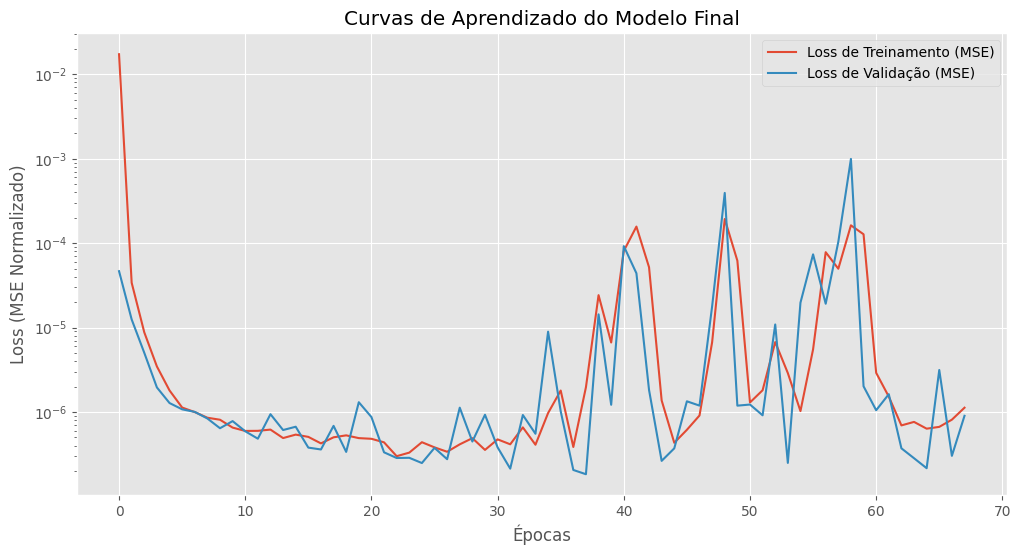

In [34]:
# --- Bloco 9: Gráfico de Treinamento (Loss vs. Epoch) ---

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Loss de Treinamento (MSE)')
plt.plot(val_losses, label='Loss de Validação (MSE)')
plt.title('Curvas de Aprendizado do Modelo Final')
#plt.ylim(0,0.0005)
plt.xlabel('Épocas')
plt.ylabel('Loss (MSE Normalizado)')
plt.yscale('log') # Usar escala logarítmica é quase obrigatório aqui
plt.legend()
plt.show()

--- Avaliação Final do Modelo ---

Métricas Finais (em escala real de R$):
  MSE:  58.83
  RMSE: 7.67
  MAPE: 0.0007 %


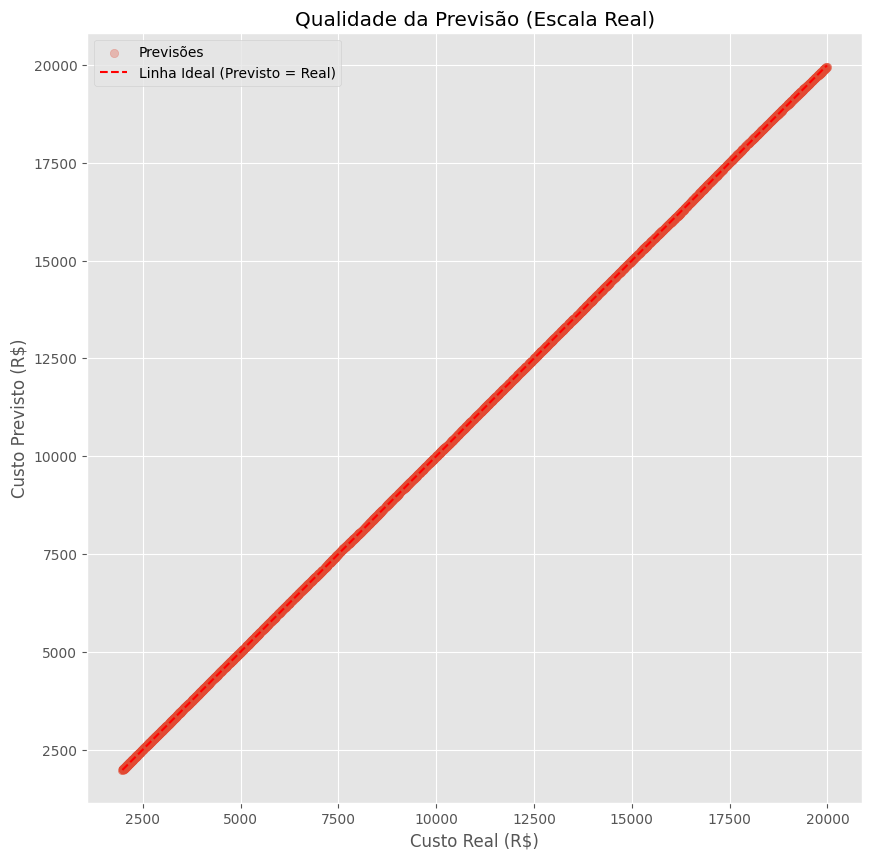

In [35]:
# --- Bloco 10: Avaliação Final (Métricas nos Dados Reais) ---

print("--- Avaliação Final do Modelo ---")

# Carregar o melhor modelo salvo
final_model.load_state_dict(torch.load('temp.pth'))
final_model.eval()

# Passar TODOS os dados (X_scaled) pelo modelo
with torch.no_grad():
    y_pred_scaled_t = final_model(torch.tensor(X_scaled, dtype=torch.float32).to(device))

# Mover para CPU e converter para NumPy
y_pred_scaled = y_pred_scaled_t.cpu().numpy()

# --- IMPORTANTE: Reverter a Normalização ---
# Agora avaliamos na escala de R$ e MW reais
y_true_real = y_scaler.inverse_transform(y_scaled)
y_pred_real = y_scaler.inverse_transform(y_pred_scaled)
x_real = x_scaler.inverse_transform(X_scaled)

# Calcular métricas finais
mse, rmse, mape = calculate_all_metrics(y_true_real, y_pred_real)

print("\nMétricas Finais (em escala real de R$):")
print(f"  MSE:  {mse:,.2f}")
print(f"  RMSE: {rmse:,.2f}")
print(f"  MAPE: {mape:.4f} %")

# --- Gráfico Final: Real vs. Previsto ---
plt.figure(figsize=(10, 10))
plt.scatter(y_true_real, y_pred_real, alpha=0.3, label='Previsões')
# Adicionar a linha ideal (y=x)
ideal_line = np.linspace(min(y_true_real.min(), y_pred_real.min()), 
                         max(y_true_real.max(), y_pred_real.max()), 100)
plt.plot(ideal_line, ideal_line, 'r--', label='Linha Ideal (Previsto = Real)')

plt.title('Qualidade da Previsão (Escala Real)')
plt.xlabel('Custo Real (R$)')
plt.ylabel('Custo Previsto (R$)')
plt.legend()
plt.grid(True)
plt.axis('equal') # Forçar eixos iguais
plt.show()

In [36]:
# --- Bloco 5: Carregamento do Modelo Pré-Treinado ---

print("--- Iniciando Treinamento por Transferência ---")

# Re-criar a arquitetura EXATA do modelo base salvo
# (É crucial que os parâmetros sejam os mesmos)
MODEL_BASE_PATH = 'temp.pth'

# Instanciar o novo modelo
transfer_model = Net(n_layers=BASE_N_LAYERS, n_neurons=BASE_N_NEURONS).to(device)

# --- A MÁGICA (Transfer Learning) ---
# Carregar os pesos (o "conhecimento") do modelo de 10 épocas
transfer_model.load_state_dict(torch.load(MODEL_BASE_PATH))
# ------------------------------------

print(f"Modelo pré-treinado '{MODEL_BASE_PATH}' carregado com sucesso.")

# Configurar o otimizador para o novo modelo
optimizer = optim.Adam(transfer_model.parameters(), lr=BASE_LR)
criterion = nn.MSELoss()

--- Iniciando Treinamento por Transferência ---
Modelo pré-treinado 'temp.pth' carregado com sucesso.


In [37]:
# --- Bloco 6: Continuação do Treinamento (Epoch 11 até o fim) ---

print("--- Continuando o treinamento (Epochs 11 a 300) ---")

# Parâmetros
N_TOTAL_EPOCHS = 300
N_EPOCHS_JA_TREINADAS = 10
EARLY_STOPPING_PATIENCE = 30 # A mesma paciência

# Listas para salvar o histórico de loss
train_losses = []
val_losses = []

best_val_loss = float('inf')
patience_counter = 0

start_time = time.time()
# Começamos o loop da época 11 até 300
for epoch in range(N_EPOCHS_JA_TREINADAS, N_TOTAL_EPOCHS):
    
    # Treinamento
    transfer_model.train()
    current_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = transfer_model(X_batch) # Usando o transfer_model
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        current_train_loss += loss.item() * X_batch.size(0)
    
    train_losses.append(current_train_loss / len(train_loader.dataset))
    
    # Validação
    transfer_model.eval()
    current_val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = transfer_model(X_batch) # Usando o transfer_model
            loss = criterion(outputs, y_batch)
            current_val_loss += loss.item() * X_batch.size(0)
            
    current_val_loss /= len(val_loader.dataset)
    val_losses.append(current_val_loss)

    # Lógica de Early Stopping
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        patience_counter = 0
        # Salvar o melhor modelo
        torch.save(transfer_model.state_dict(), 'temp.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"Treinamento por transferência parou cedo no epoch {epoch+1}")
        break

    if (epoch + 1) % 50 == 0 or epoch == N_EPOCHS_JA_TREINADAS:
        # Imprime no primeiro loop (época 10) e a cada 50
        print(f"Epoch [{epoch+1}/{N_TOTAL_EPOCHS}], Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_losses[-1]:.6f}")

end_time = time.time()
print(f"Treinamento por transferência concluído em {end_time - start_time:.2f}s")
print("Modelo 'temp.pth' salvo.")

--- Continuando o treinamento (Epochs 11 a 300) ---
Epoch [11/300], Train Loss: 0.006186, Val Loss: 0.000069
Epoch [50/300], Train Loss: 0.000155, Val Loss: 0.000012
Treinamento por transferência parou cedo no epoch 70
Treinamento por transferência concluído em 7.51s
Modelo 'temp.pth' salvo.


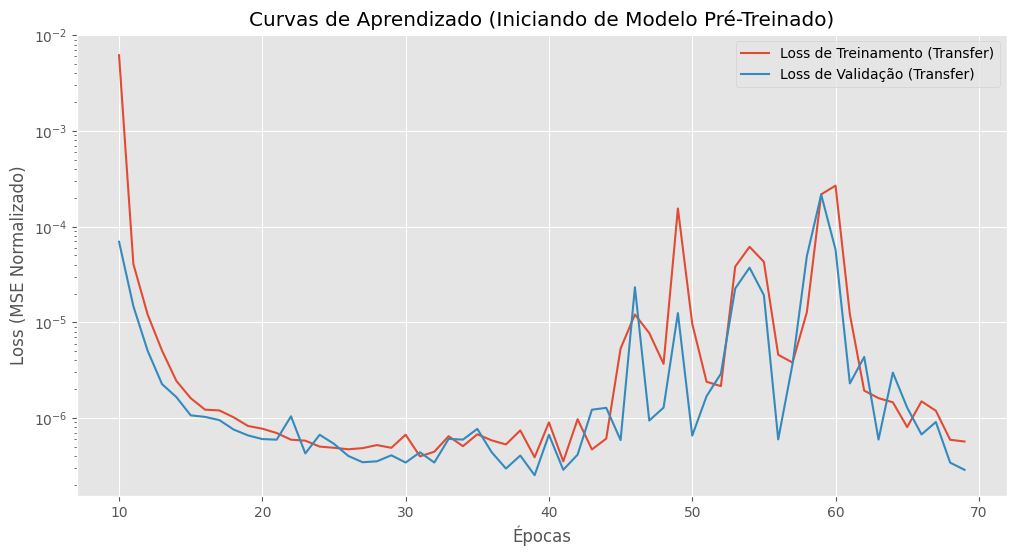

In [38]:
# --- Bloco 7: Gráfico de Treinamento (Loss vs. Epoch) ---
# Este gráfico será a prova: ele vai começar BAIXO.

plt.figure(figsize=(12, 6))
# Plotar o loss a partir da época 11
plt.plot(range(N_EPOCHS_JA_TREINADAS, N_EPOCHS_JA_TREINADAS + len(train_losses)), 
         train_losses, 
         label='Loss de Treinamento (Transfer)')
plt.plot(range(N_EPOCHS_JA_TREINADAS, N_EPOCHS_JA_TREINADAS + len(val_losses)), 
         val_losses, 
         label='Loss de Validação (Transfer)')

plt.title('Curvas de Aprendizado (Iniciando de Modelo Pré-Treinado)')
plt.xlabel('Épocas')
plt.ylabel('Loss (MSE Normalizado)')
plt.legend()
plt.yscale('log')
plt.show()

--- Avaliação Final do Modelo de Transferência ---

Métricas Finais (em escala real de R$):
  MSE:  85.13
  RMSE: 9.23
  MAPE: 0.0009 %


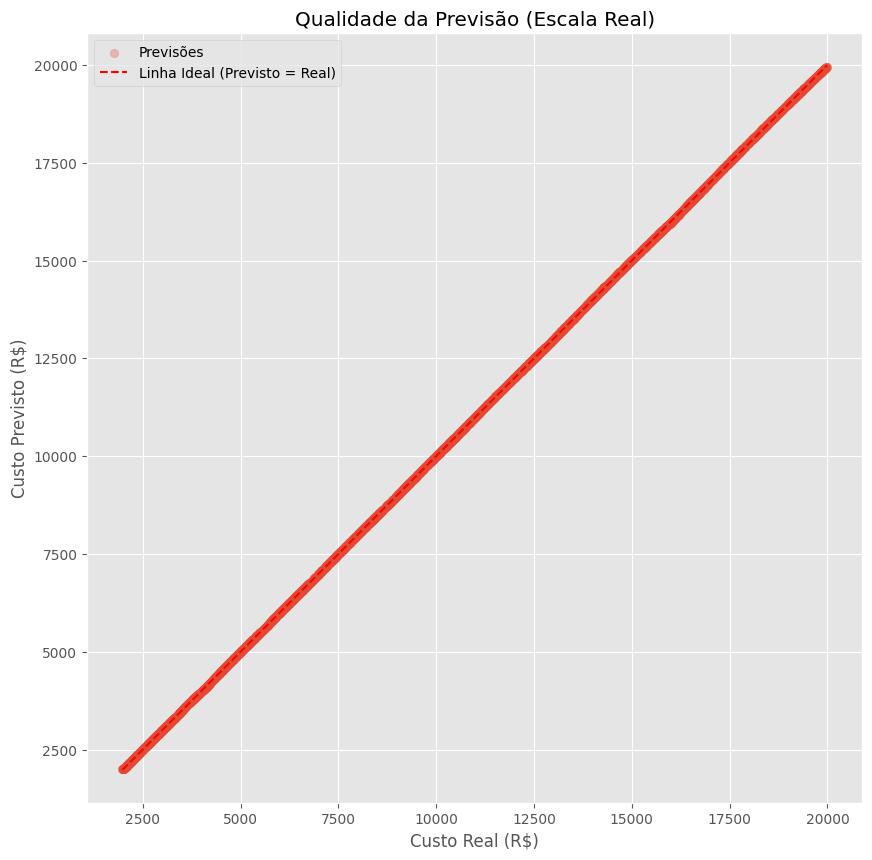

In [39]:
# --- Bloco 8: Avaliação Final (Métricas nos Dados Reais) ---
# Este bloco é idêntico ao Bloco 10 do notebook original,
# apenas carrega o 'temp.pth'

print("--- Avaliação Final do Modelo de Transferência ---")

# Carregar os scalers
x_scaler = joblib.load('x_scaler.joblib')
y_scaler = joblib.load('y_scaler.joblib')

# Carregar os dados originais (não normalizados)
X = pd.read_csv('usina_carvao_dataset.csv')[['Potencia_MW']].values
y_true_real = pd.read_csv('usina_carvao_dataset.csv')[['Custo_Real']].values

# Carregar o melhor modelo salvo
eval_model = Net(n_layers=BASE_N_LAYERS, n_neurons=BASE_N_NEURONS).to(device)
eval_model.load_state_dict(torch.load('temp.pth'))
eval_model.eval()

# Preparar dados de entrada (normalizar)
X_scaled = x_scaler.transform(X)

# Passar TODOS os dados pelo modelo
with torch.no_grad():
    y_pred_scaled_t = eval_model(torch.tensor(X_scaled, dtype=torch.float32).to(device))

# Mover para CPU e converter para NumPy
y_pred_scaled = y_pred_scaled_t.cpu().numpy()

# --- IMPORTANTE: Reverter a Normalização ---
y_pred_real = y_scaler.inverse_transform(y_pred_scaled)

# Calcular métricas finais
mse, rmse, mape = calculate_all_metrics(y_true_real, y_pred_real)

print("\nMétricas Finais (em escala real de R$):")
print(f"  MSE:  {mse:,.2f}")
print(f"  RMSE: {rmse:,.2f}")
print(f"  MAPE: {mape:.4f} %")

# --- Gráfico Final: Real vs. Previsto ---
plt.figure(figsize=(10, 10))
plt.scatter(y_true_real, y_pred_real, alpha=0.3, label='Previsões')
# Adicionar a linha ideal (y=x)
ideal_line = np.linspace(min(y_true_real.min(), y_pred_real.min()), 
                         max(y_true_real.max(), y_pred_real.max()), 100)
plt.plot(ideal_line, ideal_line, 'r--', label='Linha Ideal (Previsto = Real)')

plt.title('Qualidade da Previsão (Escala Real)')
plt.xlabel('Custo Real (R$)')
plt.ylabel('Custo Previsto (R$)')
plt.legend()
plt.grid(True)
plt.axis('equal') # Forçar eixos iguais
plt.show()

In [40]:
'''# --- Bloco 11: Visualização do Modelo Final ("Campeão") com TensorBoard ---
# Este bloco usa SummaryWriter do PyTorch para logar o grafo do modelo,
# garantindo que a arquitetura visualizada seja a mesma que foi treinada no Bloco 8.
# Nota: Você precisa ter 'tensorboard' instalado (`pip install tensorboard`)

print("\n--- Logando Grafo da Rede 'Campeã' para TensorBoard ---")

try:
    from torch.utils.tensorboard import SummaryWriter

    # --- MUDANÇA AQUI ---
    # 1. Usar as variáveis BASE_N_LAYERS e BASE_N_NEURONS definidas no Bloco 8
    #    Estas variáveis contêm a arquitetura da rede campeã encontrada pelo Optuna.
    #    Certifique-se de que o Bloco 8 foi executado e essas variáveis existem.
    
    # Verificar se as variáveis existem (caso execute fora de ordem)
    if 'BASE_N_LAYERS' not in locals() or 'BASE_N_NEURONS' not in locals():
         raise NameError("Variáveis BASE_N_LAYERS ou BASE_N_NEURONS não definidas. Execute o Bloco 8 primeiro.")

    # Instanciar o modelo com a arquitetura correta
    #tb_model = Net(n_layers=BASE_N_LAYERS, n_neurons=BASE_N_NEURONS).to(device)
    tb_model = Net(n_layers=BASE_N_LAYERS, n_neurons=BASE_N_NEURONS).to(device)
    
    # Nome do arquivo do modelo salvo no Bloco 8
    # Certifique-se que este nome corresponde ao arquivo salvo no Bloco 8
    # (No seu código anterior era 'temp.pth')
    SAVED_MODEL_FILENAME = 'temp.pth' 
    
    # Carregar os pesos do modelo campeão
    tb_model.load_state_dict(torch.load(SAVED_MODEL_FILENAME))
    tb_model.eval()
    # --- Fim da Mudança ---

    # 2. Criar um dado de entrada falso (dummy input) com batch size pequeno
    dummy_input_tb = torch.randn(BATCH_SIZE, 1).to(device) # Usar batch_size=1 para o gráfico mais limpo

    # 3. Criar o SummaryWriter
    log_dir = "runs/diagrama_rede_relu_1_layer" # Mesmo diretório
    writer = SummaryWriter(log_dir)

    # 4. Adicionar o grafo ao TensorBoard
    writer.add_graph(tb_model, dummy_input_tb)

    # 5. Fechar o writer
    writer.close()

    print(f"Grafo do modelo '{SAVED_MODEL_FILENAME}' logado com sucesso em: '{log_dir}'")
    print("Para visualizar, abra o terminal e execute:")
    print(f"python -m tensorboard.main --logdir={log_dir}")
    print("Depois, acesse o endereço (geralmente http://localhost:6006/) no seu navegador.")


except ImportError:
    print("Biblioteca 'tensorboard' não encontrada. Instale com 'pip install tensorboard'.")
except NameError as e:
    print(f"Erro: {e}")
except FileNotFoundError:
     print(f"ERRO: Arquivo do modelo '{SAVED_MODEL_FILENAME}' não encontrado.")
     print("Verifique o nome do arquivo salvo no Bloco 8.")
except Exception as e:
    print(f"Erro ao logar grafo para TensorBoard: {e}")


# python -m tensorboard.main --logdir=runs/diagrama_rede_relu_3_layers
# python -m tensorboard.main --logdir=runs/diagrama_rede_relu_2_layers
# python -m tensorboard.main --logdir=runs/diagrama_rede_relu_1_layer'''

'# --- Bloco 11: Visualização do Modelo Final ("Campeão") com TensorBoard ---\n# Este bloco usa SummaryWriter do PyTorch para logar o grafo do modelo,\n# garantindo que a arquitetura visualizada seja a mesma que foi treinada no Bloco 8.\n# Nota: Você precisa ter \'tensorboard\' instalado (`pip install tensorboard`)\n\nprint("\n--- Logando Grafo da Rede \'Campeã\' para TensorBoard ---")\n\ntry:\n    from torch.utils.tensorboard import SummaryWriter\n\n    # --- MUDANÇA AQUI ---\n    # 1. Usar as variáveis BASE_N_LAYERS e BASE_N_NEURONS definidas no Bloco 8\n    #    Estas variáveis contêm a arquitetura da rede campeã encontrada pelo Optuna.\n    #    Certifique-se de que o Bloco 8 foi executado e essas variáveis existem.\n    \n    # Verificar se as variáveis existem (caso execute fora de ordem)\n    if \'BASE_N_LAYERS\' not in locals() or \'BASE_N_NEURONS\' not in locals():\n         raise NameError("Variáveis BASE_N_LAYERS ou BASE_N_NEURONS não definidas. Execute o Bloco 8 primeiro.")